##### 版權所有 2024 Google LLC.

In [1]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 使用微調 PaliGemma 生成科學圖表標題

本筆記本探討使用微調 [PaliGemma](https://ai.google.dev/gemma/docs/paligemma) 模型來生成科學圖表的標題。[PaliGemma-FT](https://www.kaggle.com/models/google/paligemma-ft) 是針對特定研究數據集進行微調的研究導向模型。我們將重點關注 [PaliGemma-3b-ft-scicap-448](https://www.kaggle.com/models/google/paligemma-ft/jax/paligemma-3b-ft-scicap-448) 模型，該模型專門針對 [SciCap](https://arxiv.org/abs/2110.11624) 數據集進行訓練。

本筆記本將展示如何利用這個預訓練模型進行標題生成，並強調其潛在優勢：

* 更高解析度輸入 (448x448): 捕捉科學圖表中的更細微細節。
* [SciCap](https://arxiv.org/abs/2110.11624) 數據集微調: 專注於科學圖表標題的訓練。

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/doggy8088/gemma-cookbook/blob/zh-tw-240628/PaliGemma/Image_captioning_using_finetuned_PaliGemma.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

## 設定

### 選擇 Colab 執行環境
要完成此指南，你需要有一個資源足夠的 Colab 執行環境來執行 Gemma 模型。在這種情況下，你應該使用 L4 GPU 或 A100 GPU，因為 T4 將不足以應付：

1. 在 Colab 視窗的右上角，選擇 **▾ (Additional connection options)** 。
2. 選擇 **Change runtime type** 。
3. 在 **Hardware accelerator** 下，選擇 **T4 GPU** 。


## 安裝 Accelerate 並重新啟動核心
在開始之前，你需要安裝適當的套件並設定你的環境。


In [2]:
! pip install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 4.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

重新啟動核心後安裝套件:


In [3]:
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

## **如何存取 PaliGemma:** 

在第一次使用 PaliGemma 之前，你需要通過 [Hugging Face](https://huggingface.co/google/gemma-2b) 請求存取模型。這確保你已經接受了模型的使用條款。

由於我們將從 Hugging Face Hub 下載 PaliGemma 模型權重，你需要一個 Hugging Face 令牌來驗證你的接受。

如果你還沒有 Hugging Face 帳戶，你可以在 [Hugging Face](https://huggingface.co/join) 註冊一個帳戶。擁有帳戶後，請按照以下步驟操作：

1. 前往 [Hugging Face Gemma 模型卡](https://huggingface.co/google/gemma-2b) (因為 PaliGemma 是 Gemma 的變體) 並選擇請求存取。
2. 完成同意書並接受條款和條件。
3. 前往 [Hugging Face Hub 帳戶設定](https://huggingface.co/settings/tokens) 並建立一個新的存取令牌。
3. 複製你的令牌。
4. 在 Colab 中，選擇 Secrets (🔑) 並添加你的 Hugging Face 存取令牌。將你的令牌儲存為所需名稱 'HF_TOKEN' 並將你的令牌儲存為名稱值。


In [1]:
from google.colab import userdata
import os

try:
    access_token = userdata.get("HF_TOKEN")
except ImportError:
    access_token = os.environ["HF_TOKEN"]

## 匯入函式庫


In [2]:
from transformers import AutoProcessor, PaliGemmaForConditionalGeneration
from PIL import Image
import requests
import torch
import matplotlib

## Configuration
在你的環境中設定 cuda 以降低 RAM 要求


In [3]:
torch.backends.cuda.enable_mem_efficient_sdp(False)
torch.backends.cuda.enable_flash_sdp(False)

## Image: Comparison of Common Loss Functions
我們將使用比較常見損失函數的圖作為範例，生成此類科學圖表的標題。
來源: [Wikipedia](https://en.wikipedia.org/wiki/Loss_function)。

我們將展示這些模型在相同科學圖表上使用各種提示的表現：

* caption en: 生成一個一般的英文標題。
* caption in detail: 提供更詳細的圖表描述。
* caption the figure: 建立一個簡明的標題，總結圖表的內容。


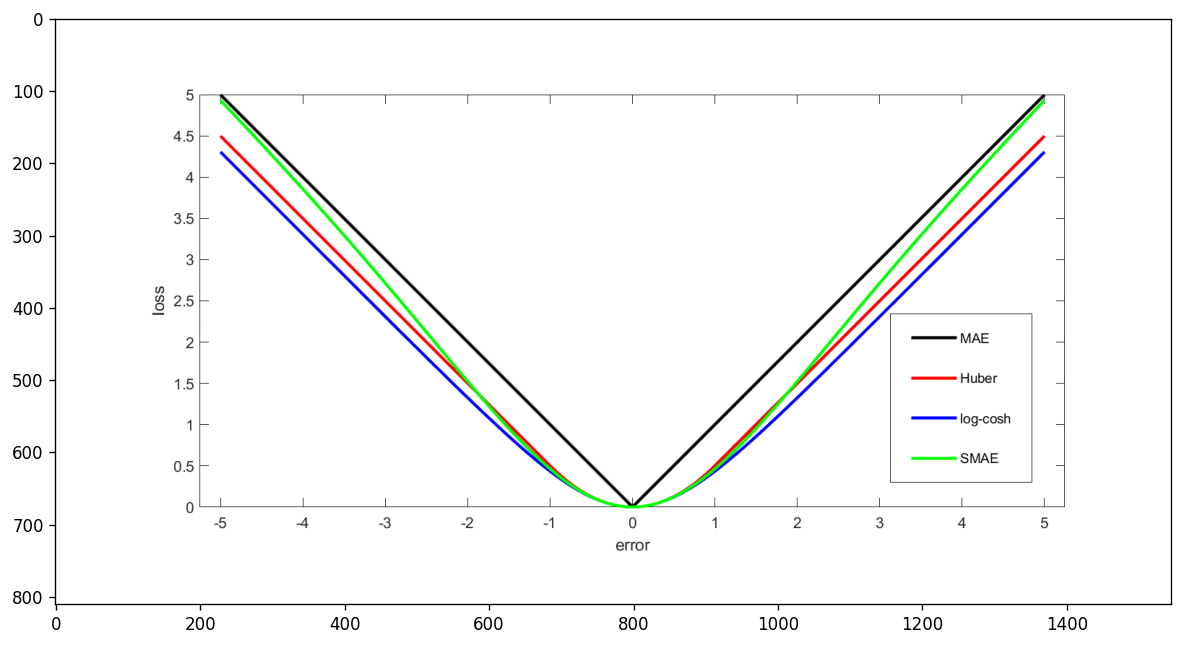

In [10]:
from urllib.request import urlopen

url = "https://upload.wikimedia.org/wikipedia/commons/e/e3/Comparison_of_loss_functions.png?download=true"
image = Image.open(urlopen(url))

matplotlib.pyplot.figure(figsize=(12, 10), dpi=120)
matplotlib.pyplot.imshow(image)
matplotlib.pyplot.show()

## 加載 PaliGemma 模型及其相應的 tokenizer。


In [11]:
def load_paligemma_model(model_id, access_token):
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    dtype = torch.bfloat16

    # Load the model
    model = PaliGemmaForConditionalGeneration.from_pretrained(
        model_id,
        torch_dtype=dtype,
        device_map=device,
        revision="bfloat16",
        token=access_token,
    ).eval()

    # Load the corresponding tokenizer
    processor = AutoProcessor.from_pretrained(model_id, token=access_token)
    return processor, model

## 產生標題


In [12]:
def generate_answer(processor, model, image):
    """
    Generates captions for an image using a PaliGemma model with various prompts.

    Args:
      processor (transformers.AutoProcessor): The tokenizer for the PaliGemma model.
      model (transformers.PaliGemmaForConditionalGeneration): The loaded PaliGemma model.
      image: A preprocessed image tensor in the format expected by the model.

    Returns:
      list: A list of generated captions corresponding to the provided prompts.
    """

    prompts = [
        "caption en\n",
        "caption in detail\n",
        "caption the figure\n",
    ]
    images = [image] * len(prompts)

    # Prepare model inputs with padding and truncation
    model_inputs = processor(
        text=prompts, images=images, return_tensors="pt", padding=True
    ).to(model.device)
    input_len = model_inputs["input_ids"].shape[-1]

    # Generate captions with beam search (inference mode)
    with torch.inference_mode():
        generation = model.generate(**model_inputs, max_new_tokens=100, do_sample=False)
        generated_texts = generation[:, input_len:]
        decoded_texts = [
            processor.decode(text, skip_special_tokens=True) for text in generated_texts
        ]

    for i, (prompt, decoded_text) in enumerate(zip(prompts, decoded_texts)):
        print(f"Question: {prompt}")
        print(f"Answer: {decoded_text}\n")

    matplotlib.pyplot.figure(figsize=(12, 10), dpi=120)
    matplotlib.pyplot.imshow(image)
    matplotlib.pyplot.show()

## 推論與基礎模型 (PaliGemma-3b-pt-224)
在我們使用微調模型之前，讓我們看看 PaliGemma 基礎模型如何回應準備好的提示。

由於此模型尚未專門針對科學圖表的標註進行微調，因此你可以預期其回應會較不準確。

**以下是基礎模型的簡要描述** ：

* Transformers PaliGemma 3B 權重。
* 使用 224x224 輸入圖像和 128 個 token 輸入/輸出文本序列進行預訓練。
* 在多種數據集上訓練。
* 可用於 float32、bfloat16 和 float16 格式進行微調。


config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/62.6k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/862M [00:00<?, ?B/s]

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/699 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/40.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.26M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/607 [00:00<?, ?B/s]

Question: caption en

Answer: a plot of a comparison of methods .

Question: caption in detail

Answer: graf von figure in the surrounding text

Question: caption the figure

Answer: figure est un diagramme de la figure



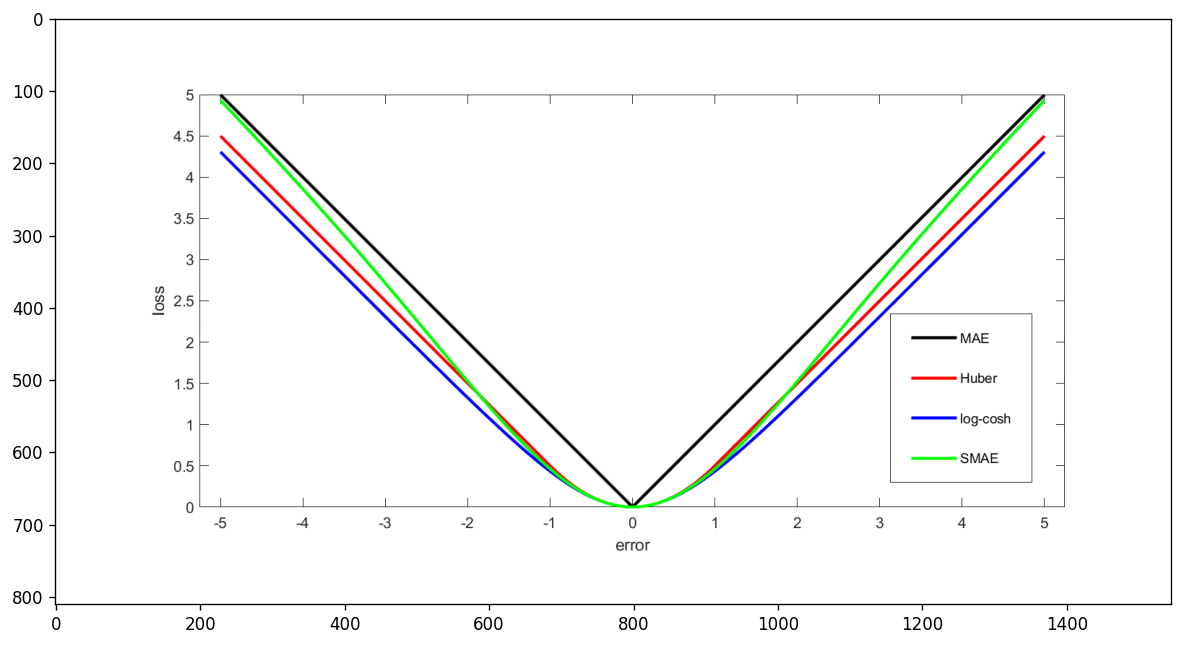

In [13]:
model_id = "google/paligemma-3b-pt-224"
processor, model = load_paligemma_model(model_id, access_token)

generate_answer(processor, model, image)

## 使用微調模型進行推論 (PaliGemma-3b-ft-scicap-224)
我們之前探討了基礎模型的表現。現在，讓我們看看微調模型對相同提示的回應。

這個模型 (PaliGemma-3b-ft-scicap-224) 已經專門在使用 SciCap 資料集的科學圖表上進行微調。因此，與基礎模型 (PaliGemma-3b-pt-224) 相比，你可以期待更準確和相關的標題。

**以下是微調模型的快速概述:** 
* Transformers PaliGemma 3B 權重: 這是微調模型的起點。
* 使用 224x224 輸入圖像進行微調: 該模型被微調以處理此大小的圖像。
* SciCap 資料集: 此資料集專門關注科學圖表及其標題。

**SciCap: 為科學圖表生成標題** :

你可以在以下[論文](https://arxiv.org/pdf/2110.11624)中找到更多關於 [SciCap 資料集](https://arxiv.org/abs/2110.11624) 的詳細資訊。

論文摘要: 這篇論文介紹了 SciCap 資料集，這是一個包含大量科學圖表及其相應標題的集合。作者討論了為科學圖表生成標題的挑戰以及此類模型的潛在好處。


config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/62.6k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/862M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/699 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/40.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.26M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/607 [00:00<?, ?B/s]

Question: caption en

Answer: different values of loss function based on error .

Question: caption in detail

Answer: comparison of four different loss functions with similar nonlinearities , in terms of error .

Question: caption the figure

Answer: shows the comparison of loss functions . the red line shows the relu loss , the black line shows the hinge loss , the blue line shows the quadratic loss and the green line shows the savage loss .



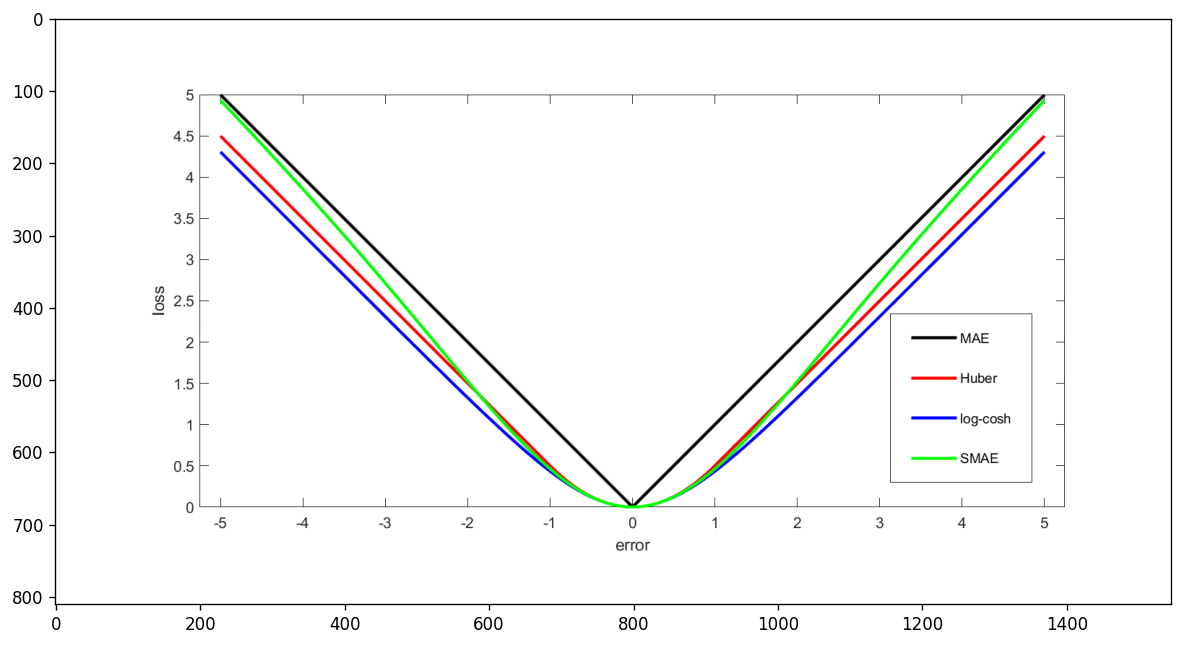

In [14]:
model_id = "google/paligemma-3b-ft-scicap-224"
processor, model = load_paligemma_model(model_id, access_token)

generate_answer(processor, model, image)

## 推論與微調模型 (PaliGemma-3b-ft-scicap-448)

基於前一個模型 (PaliGemma-3b-ft-scicap-224) 的成功，我們來探索 PaliGemma-3b-ft-scicap-448 的功能。由於兩個關鍵改進，此模型可能提供更好的標註：

* 更高解析度輸入 (448x448): 該模型經過微調以處理更高解析度的圖像，可能捕捉到科學圖形中的更細微細節。
* 利用 SciCap 數據集: 與前一個模型類似，它在專為科學圖形標註設計的 SciCap 數據集上進行微調。

雖然該模型無法進行微調，但你仍然可以從其預訓練功能中受益，用於研究目的。這些模型有 float32、bfloat16 和 float16 格式可用。

微調配置:

* 有關微調配置的更多詳細資訊，你可以參考 [big_vision](https://github.com/google-research/big_vision/blob/main/big_vision/configs/proj/paligemma/transfers/scicap.py)。



config.json:   0%|          | 0.00/1.09k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/62.6k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/862M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/700 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/40.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.26M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/607 [00:00<?, ?B/s]

Question: caption en

Answer: different loss functions . mae , huber , logistic loss , squared error ( sme ) .

Question: caption in detail

Answer: shows the difference between standard mae , huber , logistic loss functions and smae . the horizontal axis shows the error and the vertical shows the difference .

Question: caption the figure

Answer: shows the different loss function . the loss function of mae clearly outperforms the other loss functions .



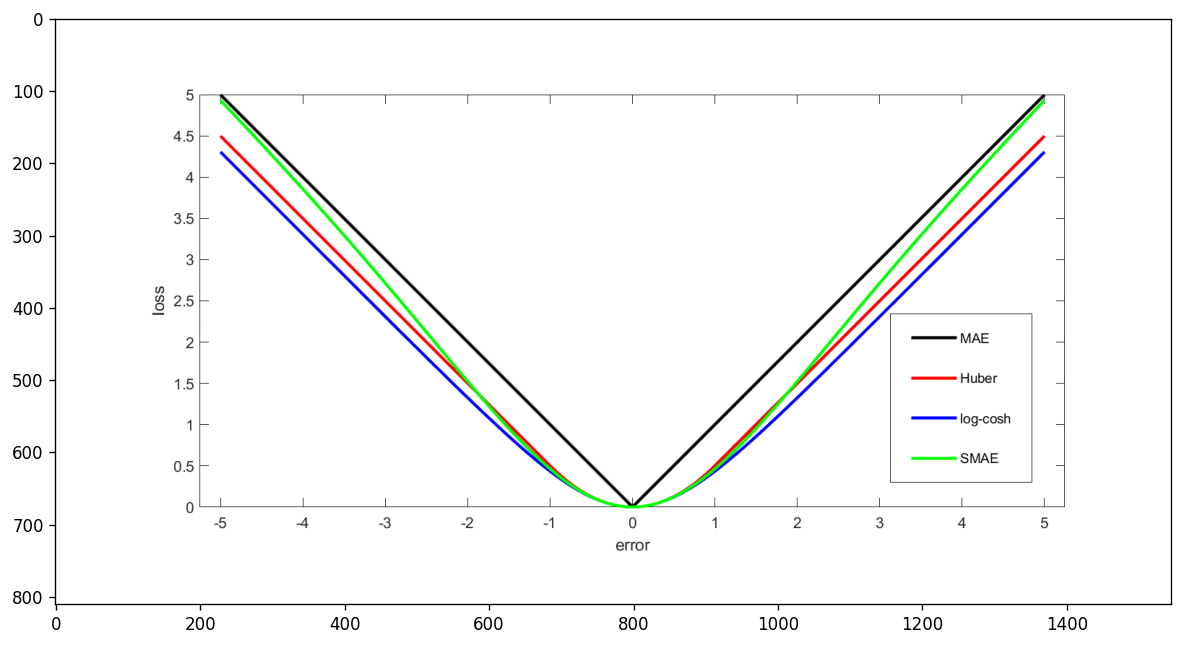

In [15]:
model_id = "google/paligemma-3b-ft-scicap-448"
processor, model = load_paligemma_model(model_id, access_token)

generate_answer(processor, model, image)

# 參考

- [PaliGemma-FT](https://www.kaggle.com/models/google/paligemma-ft): 針對特定研究數據集進行微調的研究導向模型。
- [SciCap](https://arxiv.org/abs/2110.11624): 為科學圖表生成標題。
- [Loss_function](https://en.wikipedia.org/wiki/Loss_function): 來自 Wikipedia 的圖表來源。
